In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [67]:
TRAIN_PATH = 'train.csv'
train = pd.read_csv(TRAIN_PATH)

In [68]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train, test_size=0.2)

In [8]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
575,576,0,3,"Patchett, Mr. George",male,19.0,0,0,358585,14.5000,NaN,S
703,704,0,3,"Gallagher, Mr. Martin",male,25.0,0,0,36864,7.7417,NaN,Q
663,664,0,3,"Coleff, Mr. Peju",male,36.0,0,0,349210,7.4958,NaN,S
337,338,1,1,"Burns, Miss. Elizabeth Margaret",female,41.0,0,0,16966,134.5000,E40,C
720,721,1,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.0,0,1,248727,33.0000,NaN,S


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 575 to 270
Data columns (total 12 columns):
PassengerId    712 non-null int64
Survived       712 non-null int64
Pclass         712 non-null int64
Name           712 non-null object
Sex            712 non-null object
Age            565 non-null float64
SibSp          712 non-null int64
Parch          712 non-null int64
Ticket         712 non-null object
Fare           712 non-null float64
Cabin          167 non-null object
Embarked       710 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [10]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,565.000000,712.000000,712.000000,712.000000
mean,442.591292,0.377809,2.317416,29.746460,0.521067,0.373596,32.425549
std,255.775581,0.485180,0.840487,14.670777,1.105977,0.811853,51.045750
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.750000,0.000000,2.000000,20.000000,0.000000,0.000000,7.917700
50%,440.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.400000
75%,665.250000,1.000000,3.000000,39.000000,1.000000,0.000000,31.068750
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
train.loc[train.index[0]]

PassengerId                     576
Survived                          0
Pclass                            3
Name           Patchett, Mr. George
Sex                            male
Age                              19
SibSp                             0
Parch                             0
Ticket                       358585
Fare                           14.5
Cabin                           NaN
Embarked                          S
Name: 575, dtype: object

In [56]:
train[(train.Ticket.apply(lambda x: x.startswith('CA'))) & (train.Survived==1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,ParentlessChild,LonelyChild


Google says that these are probably group tickets.. ignoring them for now (setting to pd.nan in formatting)

# Feature Engineering - playing with pandas

In [18]:
train['ParentlessChild'] = (train.Age<18) & (train.Parch==0)

In [19]:
len(train[train['ParentlessChild']==True])

26

In [20]:
train['LonelyChild'] = (train.ParentlessChild) & (train.SibSp==0)

In [21]:
len(train[train['LonelyChild']==True])

18

In [22]:
lc = train[train['LonelyChild']==True]

In [43]:
pcalssVsSurv = lc[['Survived','Pclass']]
pcalssVsSurv.groupby(lc.Pclass).Survived.mean()

Pclass
1    1.000
2    0.000
3    0.375
Name: Survived, dtype: float64

/home/guy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


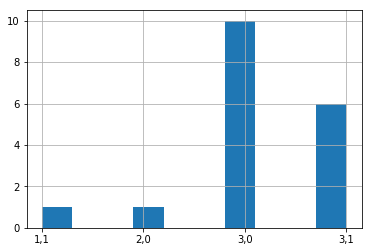

In [51]:
pcalssVsSurv['PcalssSurv'] = pcalssVsSurv.Pclass.astype(str) + ',' + pcalssVsSurv.Survived.astype(str)
pcalssVsSurv['PcalssSurv'].hist()

## Is being a lonely child (hence probably with a nany) correlated with social economic status?

In [72]:
pop_mean = train['Pclass'].mean()
pop_std  = train['Pclass'].std()

In [73]:
lc = train[train.LonelyChild==True]
sample_mean = lc['Pclass'].mean()
sample_std  = lc['Pclass'].std()

In [74]:
apx_z_score = (sample_mean - pop_mean)/pop_std

In [75]:
apx_z_score

0.5258701602023518

In [84]:
from scipy.stats import norm
pv = 1-norm.cdf(apx_z_score)
pv

0.29948921145819285

so slightly correlated


# Formatting

In [69]:
df = train.copy()

In [70]:
surv = df['Survived']
df = df.drop(['Survived','Name','Cabin','Embarked'],axis=1)

In [71]:
# Making numeric
df['Sex'] = train.Sex.replace(['male','female'],[0,1])

In [72]:
#ignoring non numeric tickets for now
df['Ticket'] = df['Ticket'].apply(lambda x: x if x.isdigit() else np.nan)

In [73]:
#fill all missing data using mean
df = df.fillna(df.mean())

In [74]:
def format_numeric_no_nan(data):
    df = data.copy()
    surv = df['Survived']
    df = df.loc[:, ~df.columns.isin(['Survived','Name','Cabin','Embarked'])]
    # Making numeric
    df['Sex'] = df['Sex'].apply(lambda x: 0 if x=='female' else 1)
    #ignoring non numeric tickets for now
    df['Ticket'] = df['Ticket'].apply(lambda x: float(x) if x.isdigit() else np.nan)
    #fill all missing data using mean
    df = df.fillna(df.mean())
    return df,surv

# Basic Random Forest Classifier

In [75]:
from sklearn.ensemble import RandomForestClassifier

In [76]:
clsfr = RandomForestClassifier(n_estimators=10)

In [109]:
#ignoring some non numeric fields and the labels themselves
df,surv = format_numeric_no_nan(train)
clsfr.fit(df, surv)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [110]:
test_x,test_y = format_numeric_no_nan(test)
clsfr.score(test_x,test_y)

0.8268156424581006

# Reviewing errors

In [79]:
pred = clsfr.predict(test_x)
errs = test_x[pred != test_y]

In [80]:
errs['Survived'] = test_y[pred != test_y]

/home/guy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [87]:
errs

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Survived
271,272,3,1,25.000000,0,0,206178.007143,0.0000,1
187,188,1,1,45.000000,0,0,111428.000000,26.5500,1
487,488,1,1,58.000000,0,0,11771.000000,29.7000,0
737,738,1,1,35.000000,0,0,206178.007143,512.3292,1
297,298,1,0,2.000000,1,2,113781.000000,151.5500,0
226,227,2,1,19.000000,0,0,206178.007143,10.5000,1
501,502,3,0,21.000000,0,0,364846.000000,7.7500,0
312,313,2,0,26.000000,1,1,250651.000000,26.0000,0
286,287,3,1,30.000000,0,0,345774.000000,9.5000,1
36,37,3,1,30.941489,0,0,2677.000000,7.2292,1


In [265]:
errs.Survived.value_counts()

0    16
1    14
Name: Survived, dtype: int64

# Remove TicketID and PassengerID which are probably not relevant features

In [76]:
clsfr2 = RandomForestClassifier(n_estimators=10)

In [97]:
#ignoring some non numeric fields and the labels themselves
df,surv = format_numeric_no_nan(train)
df.drop(['Ticket','PassengerId'],axis=1,inplace=True)
clsfr2.fit(df, surv)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [98]:
test_x,test_y = format_numeric_no_nan(test)
test_x.drop(['Ticket','PassengerId'],axis=1,inplace=True)
clsfr2.score(test_x,test_y)

0.7877094972067039

It seems to be slightly worse, maybe the ticket/Id gives some prediction on location in the ship etc.

# Use cabin with missing data as -1

In [163]:
import re
def add_cabin_let_num(df):
    df['CabinLetters'] = df.Cabin.apply(lambda x: list(filter(str.isalpha, x))[0] if x!=-1 else -1)
    def f(x):
        try:
            return re.findall('\d+',x)[0] if x!=-1 else -1
        except:
            return -2
    df['CabinNumber'] = df.Cabin.apply(f)
    df.drop('Cabin',axis=1,inplace=True)
    df = pd.get_dummies(df,columns=['CabinLetters'])
    return df

In [154]:
clsfr3 = RandomForestClassifier(n_estimators=10)

In [159]:
#ignoring some non numeric fields and the labels themselves

df,surv = format_numeric_no_nan(train)
df['Cabin'] = train.Cabin.fillna(-1)
df = add_cabin_let_num(df)

In [157]:
clsfr3.fit(df, surv)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [167]:
test_x,test_y = format_numeric_no_nan(test)
test_x['Cabin'] = test.Cabin.fillna(-1)

In [168]:
test_x = add_cabin_let_num(test_x)

#clsfr3.score(test_x,test_y)

We don't have the same CabinLetters in train and test, so we need to generate one hot labels for the train, and add another column for 'unknown' to 